In [279]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
PATH = "MNIST Data/"
train_path = f'{PATH}train.csv'
test_path = f'{PATH}test.csv'

In [3]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [4]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [637]:
class RBM(object):
    def __init__(self, input = None, n_visible = 1, n_hidden = 1, 
                W = None, hbias = None, vbias = None, numpy_rng = None):
        
        self.n_visible = n_visible #num of visible unit
        self.n_hidden = n_hidden #num of hidden unit
        
        if numpy_rng is None:
            numpy_rng = np.random.RandomState(123)
            
        if W is None:
            a = 1. / n_visible
            initial_W = np.array(numpy_rng.uniform(
                        low = -a, 
                        high = a, 
                        size = (n_visible, n_hidden)
                            )
                        )
            W = initial_W
        
        if hbias == None:
            hbias = np.zeros(n_hidden)
        
        if vbias == None:
            vbias = np.zeros(n_visible)
        
        self.numpy_rng = numpy_rng
        self.hbias = hbias
        self.vbias = vbias
        self.W = W
        self.input = input
        self.energy_plot = []
        self.error_plot = []
        
    def contrastive_divergence(self, lr = 0.1, k = 1):
        ph_mean, ph_sample = self.get_hid_state(self.input)
        
        cur_sample = ph_sample
        
        for step in range(k):
            nv_mean, nv_sample = self.get_vis_state(cur_sample)
            nh_mean, nh_sample = self.get_hid_state(nv_sample)
            cur_sample = nh_sample
                
        delta_W = lr * (np.mean(np.dot(self.input.T, ph_sample) - np.dot(nv_sample, nh_sample)))
        
        delta_hbias = lr * np.mean(ph_sample - nh_sample)
        delta_vbias = lr * np.mean(self.input.T - nv_sample)
        
        self.W += delta_W
        self.hbias += delta_hbias
        self.vbias += delta_vbias
        
        energy = self.get_energy(v = nv_mean, h = nh_mean)
        error = self.get_error(v_init = self.input.T, v_recon = nv_mean)
        
        return [energy, error]
        
    def propup(self, v):
        z = np.dot(v.T, self.W) + self.hbias
        return sigmoid(z)
    
    def propdown(self, h):
        z = np.dot(self.W, h.T) + self.vbias
        return sigmoid(z)
    
    def get_hid_state(self, v_sample):
        h_mean = self.propup(v_sample)
        h_sample = self.numpy_rng.binomial(size = h_mean.shape, 
                                            n = 1, #bernoulli distribution
                                            p = h_mean)
        return [h_mean, h_sample]
    
    def get_vis_state(self, h_sample):
        v_mean = self.propdown(h_sample)
        v_sample = self.numpy_rng.binomial(size = v_mean.shape, 
                                            n = 1, 
                                            p = v_mean)
        return [v_mean, v_sample]
      
    def get_energy(self, v = None, h = None):
        energy = -np.sum(np.multiply(np.dot(v, h), self.W)) - np.sum(np.dot(self.vbias, v)) - np.sum(np.dot(self.hbias, h.T))
        return energy
    
    def get_error(self, v_init = None, v_recon = None):
        error = np.sum(np.square(v_init - v_recon))
        return error
        
    def train(self, n_epoch = 1000, lr = 0.1, k = 1):
        for epoch in range(n_epoch):
            energy, error = self.contrastive_divergence(lr = lr, k = k)
            self.energy_plot.append(energy)
            self.error_plot.append(error)
            if epoch % 100 == 0:
                print('training epoch %s, energy is %s, error is %s' % (epoch, energy, error))
    
    def plot_energy(self):
        energy_plot = []
        cumsum = [0]
        n_window = 10
        for i, energy in enumerate(self.energy_plot):
            cumsum.append(cumsum[i-1] + energy)
            if i >= n_window:
                moving_ave = (cumsum[i] - cumsum[i - n_window])/n_window
                energy_plot.append(moving_ave)
            
        plt.plot(energy_plot)
        plt.show()
        
    def plot_error(self):
        error_plot = []
        cumsum = [0]
        n_window = 10
        for i, error in enumerate(self.error_plot):
            cumsum.append(cumsum[i - 1] + error)
            if i >= n_window:
                moving_ave = (cumsum[i] - cumsum[i-n_window])/n_window
                error_plot.append(moving_ave)
        
        plt.plot(error_plot)
        plt.show()
    
    def disp_weights(self):
        #print(self.W)
        plt.hist(self.W.reshape((self.n_visible * self.n_hidden, 1)), bins = 10)
        plt.show()

In [647]:
data = np.array([[1,1,1,0,0,0],
                 [1,0,1,0,0,0],
                 [1,1,1,0,0,0],
                 [0,0,1,1,1,0],
                 [0,0,1,1,0,0],
                 [0,0,1,1,1,0]])
rng = np.random.RandomState(123)
n_visible = data.shape[1]
n_hidden = 2
W = np.random.normal(size = (n_visible, n_hidden))

In [648]:
rbm = RBM(input = data, n_visible = n_visible, n_hidden = n_hidden, W = W, numpy_rng = rng)

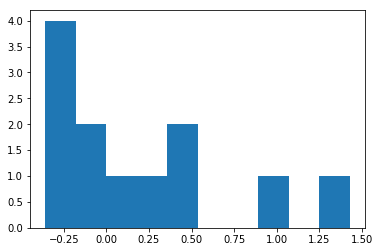

In [649]:
rbm.disp_weights()

In [650]:
rbm.train(n_epoch = 5000, k = 10, lr = 0.1)

training epoch 0, energy is -6.142404178704454, error is 12.568550103113193
training epoch 100, energy is 5.259851682881923, error is 10.292486966516302
training epoch 200, energy is 5.144799020855105, error is 10.132439087052276
training epoch 300, energy is 5.158330639839996, error is 9.793353225043994
training epoch 400, energy is 4.793731130836485, error is 8.892887349248486
training epoch 500, energy is 4.972081884790664, error is 11.145038666518548
training epoch 600, energy is 5.139352147786868, error is 8.896641475519242
training epoch 700, energy is 3.566121955290675, error is 9.02712101641104
training epoch 800, energy is 5.694737692909124, error is 9.880431202868401
training epoch 900, energy is 5.4921026703259725, error is 9.262660650496763
training epoch 1000, energy is 4.710396106026869, error is 10.119809017355461
training epoch 1100, energy is 6.392963514548418, error is 9.49700723608999
training epoch 1200, energy is 4.1582317626025835, error is 8.728631337827053
train

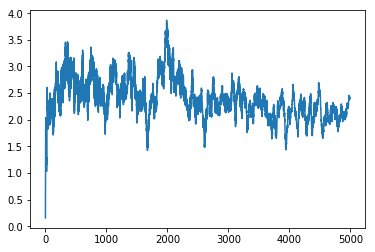

In [651]:
rbm.plot_energy()

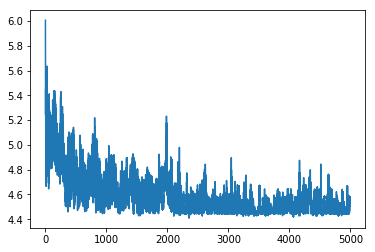

In [652]:
rbm.plot_error()

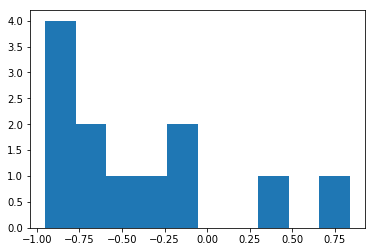

In [653]:
rbm.disp_weights()